# 02 — Modelling (ML)

This notebook builds and explores ML models which predict the propensity of patients to be readmitted

**Local data source:** `/data/interim/10kDiabetes.csv`

In [1]:
import sys
import os

project_root = os.path.abspath("..") # Add project root to Python path so we can import data_loader, preprocess, etc etc
if project_root not in sys.path:
    sys.path.append(project_root)

project_root

'C:\\work\\git\\diabetes-readmission-ml'

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Not too bothered about message "Pyarrow will become a required dependency of pandas"
    import pandas as pd

import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.4)  # try 1.3–1.6

from src.data_loader import load_diabetes_csv, DIABETES_DATA_CSV

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
df = load_diabetes_csv(DIABETES_DATA_CSV,project_root)
df.shape

(10000, 52)

In [4]:
from src.preprocess import preprocess_impute_scale_encode

ignorelist = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc']
df = df.drop(columns=ignorelist, errors='ignore')

df_preproc = preprocess_impute_scale_encode(df, 'readmitted')

# Models

In [7]:
# 2.2 Train/Test Split & Baseline Models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)

# Assume df_processed is your cleaned DataFrame & 'readmitted' is target
X = df_preproc.drop(columns=['readmitted'])
y = df_preproc['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Baseline models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

import pandas as pd
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1,ROC-AUC
LogisticRegression,0.665,0.623742,0.390921,0.480620,0.702541
RandomForest,0.649,0.592668,0.366961,0.453271,0.675015


Average Precision (PR-AUC): 0.565
Area under PR-curve (by trapezoid): 0.567


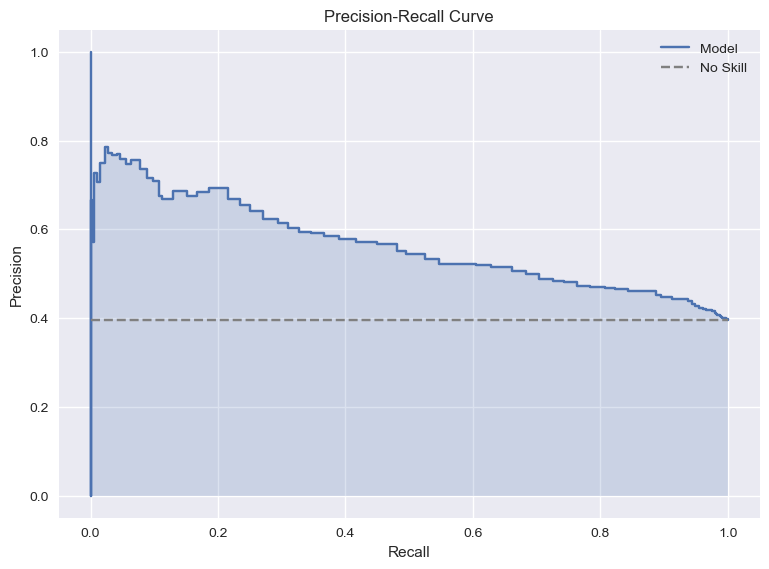

In [9]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Assume:
#   y_test – the actual binary labels (0/1) for the test set
#   y_proba – the predicted probabilities for the positive class (model.predict_proba(X_test)[:,1])

# Compute precision/recall pairs for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute average precision (PR-AUC)
pr_auc = average_precision_score(y_test, y_proba)

# Compute area under the precision-recall curve (alternate)
pr_auc_trap = auc(recall, precision)

print(f"Average Precision (PR-AUC): {pr_auc:.3f}")
print(f"Area under PR-curve (by trapezoid): {pr_auc_trap:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label='Model')
plt.fill_between(recall, precision, step='post', alpha=0.2)

# Plot the no-skill line (precision equal to prevalence)
no_skill = sum(y_test==1) / len(y_test)
plt.hlines(no_skill, 0, 1, linestyle='--', color='grey', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()